In [57]:
%%HTML
<button onclick="$('.input, .prompt, .output_stderr, .output_error').toggle();">Toggle Code</button>

In [1]:
import pandas as pd
mypath=r"C:\Users\hunzh\Desktop\RD"

In [2]:
ree=pd.read_excel(mypath+r"\rd.xlsx",0,index_col='code')# 费用化的研发支出 
rec=pd.read_excel(mypath+r"\rd.xlsx",1,index_col='code')# 资本化研发支出
re=pd.read_excel(mypath+r"\rd.xlsx",2,index_col='code')# 总研发支出
#price=pd.read_excel(mypath+r"\price.xlsx",0,index_col='code') # 股票价格序列
market=pd.read_excel(mypath+r"\marketcap.xlsx",0,index_col='code')  #总市值
#读取资本化和市值

##   计算需要的表格

In [3]:

sale=pd.read_excel(mypath+r"\sale.xlsx",0,index_col='code') #销售收入
profit=pd.read_excel(mypath+r"\profit.xlsx",0,index_col='code') #净利润
cash=pd.read_excel(mypath+r"\cash.xlsx",0,index_col='code') #现金流入
equity=pd.read_excel(mypath+r"\equity.xlsx",0,index_col='code') #所有者权益
bonus=pd.read_excel(mypath+r"\bonus.xlsx",0,index_col='code') #现金红利

In [4]:
df=pd.DataFrame(index=list(range(2013,2018)),columns=['sale','profit','bonus','equity'])
for year in range(2013,2018):
    re_y=re[year]
    re_y.name='RE'

    companys=list(re_y.index[re_y.notnull()])  #公布了研发支出的公司列表

    def get_sum(xx):
        xx_y=xx[year]
        return xx_y[xx_y.index.to_series().isin(companys)].sum()
    re_s=get_sum(re)  #所有公司RE加总
   
    for name in ['sale','profit','bonus','equity']:
        xx=eval(name)
        df.loc[year,name]=re_s/get_sum(xx)
df



,sale,profit,bonus,equity
2013,0.0175353,0.390239,1.3034,0.0342424
2014,0.0191176,0.370282,1.28146,0.0325664
2015,0.0206007,0.439709,1.26664,0.0307568
2016,0.0217257,0.407509,1.05463,0.030331
2017,0.0220084,0.364111,1.83642,0.0318167


R&D占公司各项指标的比例

In [5]:
total=re.loc[re.notnull().sum(axis=1)==6,:] 
def fff(x):
    rdc1=x[2017]+0.8*x[2016]+0.6*x[2015]
    rdc2=x[2016]+0.8*x[2015]+0.6*x[2014]
    rdc3=x[2015]+0.8*x[2014]+0.6*x[2013]
    l=[rdc1,rdc2,rdc3]
    return pd.Series(l,index=[2017,2016,2015])
#k=total.apply(lambda x:x[2017]+0.8*x[2016]+0.6*x[2015]+0.4*x[2014]+0.2*x[2013],axis=1) 
k=total.apply(fff,axis=1) 

companys=list(total.index) 

es=equity[[2015,2016,2017]]
ess=es[es.index.to_series().isin(companys)]  #所有者权益
k.sum()/ess.sum()  #RDC占所有者权益的比例

2015    0.074127
2016    0.072657
2017    0.073796
dtype: float64

RDC占所有者权益的比例

## 进行模拟交易

In [3]:
ret=pd.read_excel(mypath+r"\rets.xlsx",0)  #读取收益率序列

In [4]:
f=lambda x :format(x,'06.0f')+'.SZ'
code=ret.Stkcd.map(f)  #转换股票代码
ret.index=code #设为索引
def get_f_years(time):
    if time.month<=5:
        return time.year-2
    else:
        return time.year-1
def get_group_list(f_year,group=0):  #返回需要的股票列表
    stock_i=re[f_year].notnull() & market[f_year]!=0  #待选股票
    rdp=re[f_year][stock_i]/market[f_year][stock_i]  #计算rd/p
    cut=pd.qcut(rdp,10,labels=range(10)).astype(int) 
    return list( cut.index[cut==group] ) 

In [5]:
tr=pd.date_range('2014-06-01','2018-06-01',freq='M').map(lambda t:pd.Timestamp(year=t.year, month=t.month, day=1))
df=pd.DataFrame(index=tr,columns=['ret0','ret9'])
for t in tr:  #遍历每一个月
    retm=ret.loc[(ret.Trdmnt==t),:]  #当月的收益率
    if t.month==6:#在每年6月
        
        f_year=get_f_years(t)  #对应财报年份
        g0=get_group_list(f_year,0)  #最低组
        g0=list(  retm.index[(retm.index.to_series().isin(g0) & (retm.Mnshrtrd!=0))] )
        
        g9=get_group_list(f_year,9)  #最高组
        g9=list(  retm.index[(retm.index.to_series().isin(g9) & (retm.Mnshrtrd!=0))] )
        #print('change',len(g0),len(g9))
    else:
        pass #就沿用上一个循环的g0&g9
    ret0=retm.Mretwd[retm.index.to_series().isin(g0)].mean()
    ret9=retm.Mretwd[retm.index.to_series().isin(g9)].mean()
    ret_por=(ret9-ret0) #套利组合收益率
    if t.month==6:
        rett_por=ret_por-0.003 #手续费
    df.loc[t,'ret0']=ret0
    df.loc[t,'ret9']=ret9
    df.loc[t,'retp']=ret_por
df1=df
#df  #得到收益率曲线       

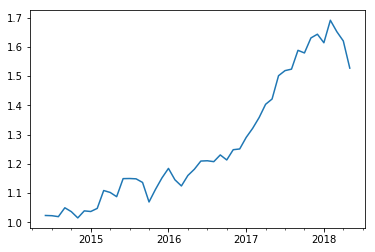

In [7]:
def cal_p(ret,name):
    ps=pd.Series(index=ret.index)
    ps.name=name
    p=1
    for t in ret.index:
        rett=ret[t]
        p=p*(1+rett)
        ps[t]=p
    return ps
cal_p(df.retp,'pp').plot()


上图为套利组合的价格走势图（最高组合减去最低组合）（已经考虑了手续费）

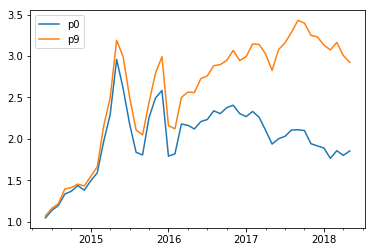

In [8]:
cal_p(df.ret0,'p0').to_frame().join(cal_p(df.ret9,'p9')).plot()

上图为最高组合与最低组合的对比，p0是R&D/p最低的组合，p9与之相反

In [18]:
# tr=pd.date_range('2016-06-01','2018-06-01',freq='M').map(lambda t:pd.Timestamp(year=t.year, month=t.month, day=1))
# df=pd.DataFrame(index=tr,columns=['ret0','ret9'])
# for t in tr:  #遍历每一个月
#     retm=ret.loc[(ret.Trdmnt==t),:]  #当月的收益率
#     if t.month==6:#在每年6月
#         f_year=get_f_years(t)  #对应财报年份
#         g0=get_group_list(f_year-2,0)  #最低组
#         g0=list(  retm.index[(retm.index.to_series().isin(g0) & (retm.Mnshrtrd!=0))] )
        
#         g9=get_group_list(f_year-2,9)  #最高组
#         g9=list(  retm.index[(retm.index.to_series().isin(g9) & (retm.Mnshrtrd!=0))] )
#         #print('change',len(g0),len(g9))
#     else:
#         pass #就沿用上一个循环的g0&g9
#     ret0=retm.Mretwd[retm.index.to_series().isin(g0)].mean()
#     ret9=retm.Mretwd[retm.index.to_series().isin(g9)].mean()
#     ret_por=(ret0-ret9) #套利组合收益率
#     if t.month==6:
#         ret_por=ret_por-0.003  #千分之三的手续费
#     df.loc[t,'ret0']=ret0
#     df.loc[t,'ret9']=ret9
#     df.loc[t,'retp']=ret_por
# cal_p(df.retp,'pp').plot()   上图为滞后两年

In [30]:
ff3=pd.read_csv(mypath+r"\ff3.csv")

In [31]:
ff3.date=ff3.date.map(lambda t:pd.Timestamp(t,freq='M')).map(lambda t:t+pd.Timedelta(days=10)).map(lambda t:pd.Timestamp(year=t.year, month=t.month, day=1))
#转化一下日期
ff3=ff3.set_index('date')

In [32]:
ff3.head()

,RM,SMB,HML
date,,,
2013-07-01,-0.1376,-0.0069,-0.0011
2013-08-01,0.0251,0.0432,0.0010
2013-09-01,0.0493,0.0378,-0.0041
2013-10-01,0.0403,0.0092,0.0059
2013-11-01,-0.0246,0.0010,0.0256


In [36]:
rm=ff3.RM

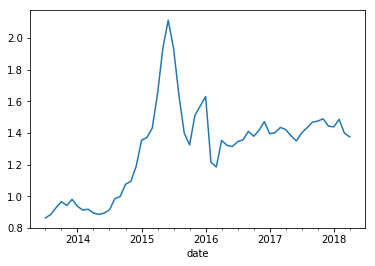

In [37]:
cal_p(rm,'market').plot() 

市场组合的价格走势

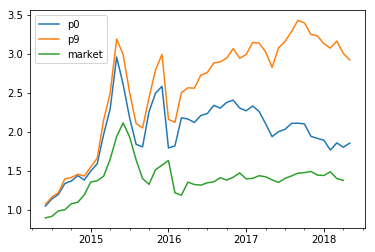

In [39]:
cal_p(df1.ret0,'p0').to_frame().join(cal_p(df1.ret9,'p9')).join(cal_p(rm,'market')).plot()

两个组合跟市场组合的对比

In [51]:
xff3=ff3.loc[ff3.index.to_series().isin(list(df1.retp.index)),:]  #对齐两边的index
y=df1.retp.loc[df1.retp.index.to_series().isin(list(ff3.index))]

In [53]:
xrm=xff3.RM  #xrm:仅有市场风险
# xff3:三因子
import statsmodels.api as sm

In [55]:

x=sm.add_constant(xrm) #增加截距项
#y=df1.retp #组合收益作为被解释变量
lg=sm.OLS(y,x)
fited=lg.fit()
fited.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   retp   R-squared:                       0.102
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     5.117
Date:                Wed, 20 Jun 2018   Prob (F-statistic):             0.0286
Time:                        20:06:08   Log-Likelihood:                 109.04
No. Observations:                  47   AIC:                            -214.1
Df Residuals:                      45   BIC:                            -210.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0093      0.004      2.598      0.013       0.002       0.017
RM             0.1041      0.046      2.262      0.029       0.011       0.197
==============================================================================
Omnibus:                        0.270   Durbin-Watson:                   2.237
Prob(Omnibus):                  0.874   Jarque-Bera (JB):                0.408
Skew:                          -0.156   Prob(JB):                        0.815
Kurtosis:                       2.668   Cond. No.                         13.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

用套利组合收益率对R_m作回归，所得到的结果，截距项和$\beta$ 值均显著,说明该超额收益不是对市场风险的补偿

In [56]:

x=sm.add_constant(xff3) #增加截距项  ff3
lg=sm.OLS(y,x)
fited=lg.fit()
fited.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   retp   R-squared:                       0.134
Model:                            OLS   Adj. R-squared:                  0.073
Method:                 Least Squares   F-statistic:                     2.213
Date:                Wed, 20 Jun 2018   Prob (F-statistic):              0.100
Time:                        20:07:23   Log-Likelihood:                 109.88
No. Observations:                  47   AIC:                            -211.8
Df Residuals:                      43   BIC:                            -204.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0099      0.004      2.668      0.011       0.002       0.017
RM             0.1037      0.049      2.115      0.040       0.005       0.203
SMB           -0.0489      0.112     -0.437      0.665      -0.274       0.177
HML           -0.1442      0.138     -1.048      0.300      -0.422       0.133
==============================================================================
Omnibus:                        1.362   Durbin-Watson:                   2.160
Prob(Omnibus):                  0.506   Jarque-Bera (JB):                0.875
Skew:                          -0.331   Prob(JB):                        0.646
Kurtosis:                       3.084   Cond. No.                         47.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

用三因子模型进行检验，发现截距仍然显著

******
### 下一步的工作：
* 试着使用其他五种指标进行分组
* 下载FF五因子数据（GTA数据库只能下载2015年之前，学校没有买之后的）


In [79]:
def get_group_list(f_year,group=0):  #返回需要的股票列表
    stock_i=rec[f_year].notnull() &(rec[f_year]!=0) & (market[f_year]!=0)  #待选股票
    rdp=rec[f_year][stock_i]/market[f_year][stock_i]  #计算rd/p
    cut=pd.qcut(rdp,10,labels=range(10)).astype(int) 
    return list( cut.index[cut==group] ) 

重新定义选股策略：根据资本化研发支出来选(0就当作是缺失值）

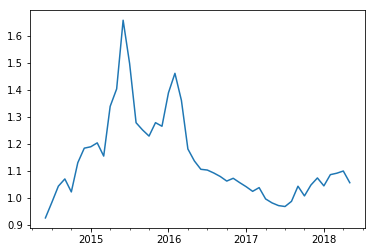

In [80]:
tr=pd.date_range('2014-06-01','2018-06-01',freq='M').map(lambda t:pd.Timestamp(year=t.year, month=t.month, day=1))
df=pd.DataFrame(index=tr,columns=['ret0','ret9'])
for t in tr:  #遍历每一个月
    retm=ret.loc[(ret.Trdmnt==t),:]  #当月的收益率
    if t.month==6:#在每年6月
        #print(t)
        f_year=get_f_years(t)  #对应财报年份
        g0=get_group_list(f_year,0)  #最低组
        g0=list(  retm.index[(retm.index.to_series().isin(g0) & (retm.Mnshrtrd!=0))] )
        
        g9=get_group_list(f_year,9)  #最高组
        g9=list(  retm.index[(retm.index.to_series().isin(g9) & (retm.Mnshrtrd!=0))] )
        #print('change',len(g0),len(g9))
    else:
        pass #就沿用上一个循环的g0&g9
    ret0=retm.Mretwd[retm.index.to_series().isin(g0)].mean()
    ret9=retm.Mretwd[retm.index.to_series().isin(g9)].mean()
    ret_por=(ret9-ret0) #套利组合收益率
    if t.month==6:
        ret_por=ret_por-0.003  #千分之三的手续费
    df.loc[t,'ret0']=ret0
    df.loc[t,'ret9']=ret9
    df.loc[t,'retp']=ret_por
cal_p(df.retp,'pp').plot()  


结果如上

In [108]:
def get_group_list(f_year,group=0):  #返回需要的股票列表
    stock_i=rec[f_year].notnull()  & (market[f_year]!=0)  #待选股票
    rdp=rec[f_year][stock_i]/market[f_year][stock_i]  #计算rd/p
    cut,b=pd.qcut(rdp,10,retbins=True,duplicates='drop')
    last=len(b)
    cut=pd.cut(rdp,b,labels=range(last-1),include_lowest=True)
    if group==0:
        return list( cut.index[cut==group] )
    else:
        return list(cut.index[cut==last-2] )

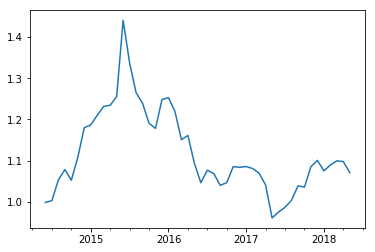

In [109]:
tr=pd.date_range('2014-06-01','2018-06-01',freq='M').map(lambda t:pd.Timestamp(year=t.year, month=t.month, day=1))
df=pd.DataFrame(index=tr,columns=['ret0','ret9'])
for t in tr:  #遍历每一个月
    retm=ret.loc[(ret.Trdmnt==t),:]  #当月的收益率
    if t.month==6:#在每年6月
        #print(t)
        f_year=get_f_years(t)  #对应财报年份
        g0=get_group_list(f_year,0)  #最低组
        g0=list(  retm.index[(retm.index.to_series().isin(g0) & (retm.Mnshrtrd!=0))] )
        
        g9=get_group_list(f_year,9)  #最高组
        g9=list(  retm.index[(retm.index.to_series().isin(g9) & (retm.Mnshrtrd!=0))] )
        #print('change',len(g0),len(g9))
    else:
        pass #就沿用上一个循环的g0&g9
    ret0=retm.Mretwd[retm.index.to_series().isin(g0)].mean()
    ret9=retm.Mretwd[retm.index.to_series().isin(g9)].mean()
    ret_por=(ret9-ret0) #套利组合收益率
    if t.month==6:
        ret_por=ret_por-0.003  #千分之三的手续费
    df.loc[t,'ret0']=ret0
    df.loc[t,'ret9']=ret9
    df.loc[t,'retp']=ret_por
cal_p(df.retp,'pp').plot()  


把资本化为0的算作最低组

In [111]:
def get_group_list(f_year,group=0):  #返回需要的股票列表
    stock_i=ree[f_year].notnull() &(ree[f_year]!=0) & (market[f_year]!=0)  #待选股票
    rdp=ree[f_year][stock_i]/market[f_year][stock_i]  #计算rd/p
    cut=pd.qcut(rdp,10,labels=range(10)).astype(int) 
    return list( cut.index[cut==group] ) 

把费用化研发支出作为选股依据

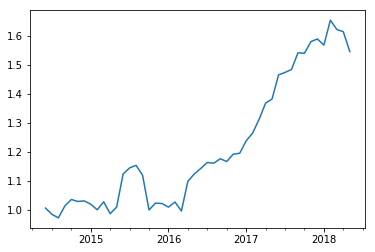

In [112]:
tr=pd.date_range('2014-06-01','2018-06-01',freq='M').map(lambda t:pd.Timestamp(year=t.year, month=t.month, day=1))
df=pd.DataFrame(index=tr,columns=['ret0','ret9'])
for t in tr:  #遍历每一个月
    retm=ret.loc[(ret.Trdmnt==t),:]  #当月的收益率
    if t.month==6:#在每年6月
        #print(t)
        f_year=get_f_years(t)  #对应财报年份
        g0=get_group_list(f_year,0)  #最低组
        g0=list(  retm.index[(retm.index.to_series().isin(g0) & (retm.Mnshrtrd!=0))] )
        
        g9=get_group_list(f_year,9)  #最高组
        g9=list(  retm.index[(retm.index.to_series().isin(g9) & (retm.Mnshrtrd!=0))] )
        #print('change',len(g0),len(g9))
    else:
        pass #就沿用上一个循环的g0&g9
    ret0=retm.Mretwd[retm.index.to_series().isin(g0)].mean()
    ret9=retm.Mretwd[retm.index.to_series().isin(g9)].mean()
    ret_por=(ret9-ret0) #套利组合收益率
    if t.month==6:
        ret_por=ret_por-0.003  #千分之三的手续费
    df.loc[t,'ret0']=ret0
    df.loc[t,'ret9']=ret9
    df.loc[t,'retp']=ret_por
cal_p(df.retp,'pp').plot() 